Instructions:

To provide training data to this notebook you can use your google drive account, to do this you need to pack your data in a zip/rar and paste it in your root directory of google drive and also uncomment the two lines of the third cell. You can also provide it uploading it right into the default root colab directory (that is content/) and changing the constant "datasetPath"

To provide your own data you need to make a folder named : 'to_predict' in the default folder of colab (content/) and upload inside of it the files you want to predict (without any packing)

In [ ]:
!pip install pyunpack

In [ ]:
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import keras
import numpy as np
from tensorflow.keras import layers
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
#path='/content/gdrive/'
#drive.mount(path)

dataset_path='/content/gdrive/MyDrive/pentoChallengeData.zip'

Mounted at /content/gdrive/


In [ ]:
from pyunpack import Archive
Archive(dataset_path).extractall('')

Constants

In [ ]:
height=224
width=224
img_dim_target=(height, width, 3)
root='/content/'
post_dir=root+'dogs/'
batch_size=2
files_to_predict=root+'to_predict/'
class_names=['french_bulldog', 'poodle', 'german_shepherd', 'golden_retriever']

Importing data to the model  (it is using 60% images for training, 20% for validating and 20% for testing )

In [ ]:
training_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    validation_split=0.4,
    batch_size=batch_size,
    image_size=(height, width),
    label_mode='categorical',
    class_names=class_names,
    subset='training',
    seed=123
)
validation_data=tf.keras.utils.image_dataset_from_directory(
    post_dir,
    shuffle=True,
    batch_size=batch_size,
    validation_split=0.4,
    image_size=(height, width),
    label_mode='categorical',
    class_names=class_names,
    subset='validation',
    seed=1234
)
#test_data is to keep some untrained fresh data to test the model
validation_data, test_data = tf.keras.utils.split_dataset (validation_data, 0.5, 0.5, shuffle=True, seed=12345)

Found 80 files belonging to 4 classes.
Using 48 files for training.
Found 80 files belonging to 4 classes.
Using 32 files for validation.


Plot some training data

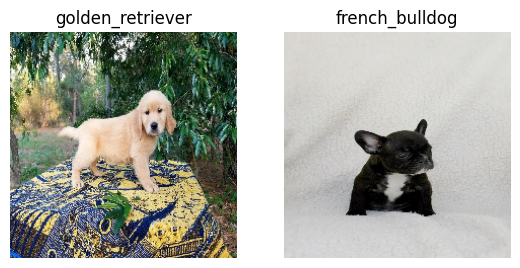

In [ ]:
classes = training_data.class_names
plt.figure(figsize=(10, 10))
cant=0

for images, labels in training_data.take(1):
  cant+=1
  for i in range(len(images)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

Data augmenter function

In [ ]:
#it there is overfit try with different data augmentation
def data_augmenter():
  y=data_augmenter=tf.keras.Sequential()
  data_augmenter.add(layers.RandomFlip("horizontal"))
  data_augmenter.add(layers.RandomRotation((-0.06, 0.06)))
  return data_augmenter

Callback

In [ ]:
class Callback1(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy')> 0.99:
      print("\n Model has reached 99% accuracy")
      self.model.stop_training= True

Model

In [ ]:
def first_model(image_shape=img_dim_target, data_augmentation=data_augmenter()):

  #setting the model which will be used to transfer its learning
  base_model=tf.keras.applications.MobileNetV2(input_shape=img_dim_target,
                                             include_top=False,
                                             weights='imagenet'
                                             )
  base_model.trainable= False

  inputs= tf.keras.Input(shape=image_shape)
  x=data_augmentation(inputs)
  x=tf.keras.applications.mobilenet_v2.preprocess_input(x)
  x=base_model(x, training=False)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  return model

model compiling and training

In [ ]:
callback=Callback1()

model=first_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

history=model.fit(training_data, validation_data=validation_data,epochs=15, callbacks=[callback])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 293ms/step - accuracy: 0.4615 - loss: 1.4581 - val_accuracy: 0.8750 - val_loss: 0.5734
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9188 - loss: 0.3711 - val_accuracy: 1.0000 - val_loss: 0.2336
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.9780 - loss: 0.1269 - val_accuracy: 1.0000 - val_loss: 0.1404
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9653 - loss: 0.1305 - val_accuracy: 1.0000 - val_loss: 0.0976
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0492
 Model has reached 99% accuracy
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 1.0000 - val_loss: 0.0808


Test accuracy in the test set

In [ ]:
predictions=model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0429


Test your own images (this shows you the prediction above the image)

In [ ]:
to_predict=os.listdir(files_to_predict)
counter=0
plt.figure(figsize=(20, 10))
rows=  np.ceil(len(to_predict)/7)

for fn in to_predict:
  path= files_to_predict +str(fn)

  image=  tf.keras.utils.load_img(path, target_size=(height,width))
  x =  tf.keras.utils.img_to_array(image)
  x = np.expand_dims(x, axis=0)
  x = np.vstack([x])
  classes = model.predict(x, batch_size=1, verbose=0)

  preds_classes = np.argmax(classes, axis=-1)

  ax = plt.subplot(3, 7, counter + 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(class_names[preds_classes[0]])

  counter+=1